In [2]:
import torch.nn as nn
import torch
import numpy as np
import torchvision
from torchvision import transforms
import dcgan
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import image_utils
import csgm
import importlib
import celeba_utils
import os
import pro_gan_pytorch.PRO_GAN as pg

In [3]:
importlib.reload(celeba_utils)

<module 'celeba_utils' from '/home/kurtis/ImageAnchors/celeba_utils.py'>

In [4]:
def closure(x):
    x = x.unsqueeze(0)
    return nn.functional.interpolate(x, size=(256,256)).squeeze()

In [5]:
data_dir = './celebA-HQ'
img_dir = 'CelebA-HQ-img/'
labels_dir = 'Anno/'

transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: closure(x)])
celebahq_train = celeba_utils.CelebA(data_dir,img_dir+'train',labels_dir+'train.txt',
                               transform=transform, mask=True, mask_transform=transform)
celebahq_test = celeba_utils.CelebA(data_dir,img_dir+'test',labels_dir+'test.txt',
                               transform=transform, mask=True, mask_transform=transform)
data_loader = torch.utils.data.DataLoader(celebahq_train,
                                          batch_size=4,
                                          shuffle=True)

(24000, 40)
(6000, 40)


In [5]:
yeet = celebahq_train[0][2]
yeet.shape

torch.Size([3, 256, 256])

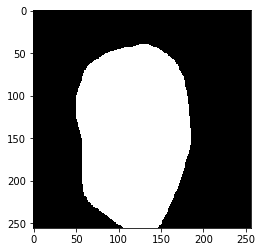

In [6]:
plt.imshow(np.moveaxis(yeet.data.cpu().numpy(),0,-1))

## Now Train

In [6]:
class P_CelebA(nn.Module):
    
    def __init__(self, z_dim = 512, nc = 1, ndf=64, ndir = 4, device = 'cuda:0'):
        super(P_CelebA,self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.z_dim = z_dim
        self.device = device
        self.ndir = ndir
        self.layers = nn.Sequential(
            # (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 64 x 64
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 32 x 32
            nn.Conv2d(ndf*4, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 4 x 4
        )
        self.mu = nn.Sequential(
#             nn.Linear(ndf*4*(3*3), ndf*4),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
            nn.Linear(ndf*4*4*4, self.z_dim*self.ndir)
        )
        
    def forward(self, X):
        X = self.layers(X).view(-1,self.ndf*4*4*4)
#         print(X.shape)
        
        return self.mu(X).chunk(self.ndir, dim=1)

## Loss

$$\mathcal{L}(X) = \mathbb{E}_Z [ ||AG(Z) - AX|| ]$$

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = torch.nn.DataParallel(pg.Generator(depth=9)).to(device)
gen.load_state_dict(torch.load("GAN_GEN_SHADOW_8.pth", map_location=str(device)))

In [8]:
device2 = torch.device('cuda:1')

In [9]:
i_se = lambda x,y: torch.sum(torch.sum(torch.mean(torch.nn.MSELoss(reduction='none')(x,y),dim=1),dim=-1),dim=-1)

## Model

In [11]:
model = P_CelebA(nc=3, ndir=2).to(device)
model.load_state_dict(torch.load('./final_celeba_hq_encoder_v2_0.pt'))
optim = torch.optim.Adam(lr=1e-3, params = model.parameters())
it = 0

In [28]:
lambda_1 = 1e-3
lambda_2 = 1e-6
epochs = 4

In [ ]:
# it = 0
# make batches fit ( only apply optimizer step every N updates)
update = 8
for e in range(1,1+epochs):
    for X,label,seg in data_loader:
        seg = seg.to(device)
        X = X.to(device)
        X = X * seg
        n_pixels = torch.sum(torch.sum(seg,dim=2),dim=2)[:,0]
        Z_list = model(X)
        c = 0
        diff_loss = 0
        for j in range(len(Z_list)):
            for k in range(j+1,len(Z_list)):
                c += 1
                distances = (torch.norm(Z_list[j] - Z_list[k], dim=1)-np.sqrt(512))**2/(512)
    #             print(distances.shape)
                diff_loss += distances.mean()
        diff_loss /= c
        Z = torch.cat(Z_list,dim=0)
        l2_loss = torch.norm(Z, dim=1).mean()
        r = len(Z_list)
    #     print(Z, Z.shape)
        Xhat = nn.functional.interpolate(gen(Z.view(-1,512), depth=8, alpha=1),size=(256,256))
    #     print(Xhat.shape)
    #     print(seg.repeat(4,1,1,1).shape)
        Xhat = (Xhat + 1)/2
        Xhat = Xhat*seg.repeat(r,1,1,1)

        errors = i_se(Xhat, X.repeat(r,1,1,1)) / (n_pixels.repeat(r)+1e-9)
        loss_r = errors.mean()
        loss = (loss_r + lambda_1 * diff_loss + lambda_2 * l2_loss)/update
        loss.backward()
    #     print(it)
        if it % update == 0:
            # now update
            optim.step()
            optim.zero_grad()
        it += 1
        if it % 10 == 0:
            print(it, ":", loss_r.item(), diff_loss.item(), l2_loss.item())
#         break
    try:
        torch.save(model.state_dict(), './final_celeba_hq_encoder_v2_' + str(e) + '.pt')
    except:
        pass
# torch.save(model.state_dict(), )

10 : 0.041179560124874115 4.939014434814453 162.059326171875
20 : 0.05955953150987625 0.6204500198364258 107.84960174560547
30 : 0.03878851979970932 0.4257068634033203 140.38645935058594
40 : 0.06256096065044403 0.3673417568206787 89.65849304199219
50 : 0.05718131363391876 1.0078833103179932 208.26846313476562
60 : 0.02679053694009781 0.8035366535186768 278.12786865234375
70 : 0.05478765070438385 2.4062671661376953 267.1513671875
80 : 0.048873305320739746 0.20874692499637604 108.5391616821289
90 : 0.04089152812957764 0.18312177062034607 127.45748901367188
100 : 0.07269729673862457 0.6797545552253723 185.26443481445312
110 : 0.03338877856731415 1.1149324178695679 356.9220275878906
120 : 0.035961784422397614 1.6114966869354248 208.29824829101562
130 : 0.02593810483813286 2.2226712703704834 360.429443359375
140 : 0.03277970105409622 2.360206365585327 377.1770935058594
150 : 0.020903030410408974 2.698070764541626 532.7154541015625
160 : 0.05801333487033844 0.26785093545913696 234.881378173

1280 : 0.02792610414326191 0.05588792264461517 174.5667724609375
1290 : 0.020916178822517395 0.16537408530712128 152.0092315673828
1300 : 0.030854618176817894 0.09069783985614777 100.73168182373047
1310 : 0.035652872174978256 0.2558497488498688 55.64471435546875
1320 : 0.03717905282974243 0.06975077092647552 123.29434204101562
1330 : 0.012785876169800758 0.2802448570728302 98.26431274414062
1340 : 0.08361436426639557 0.07203378528356552 109.04024505615234
1350 : 0.03140374273061752 0.054705847054719925 155.8955841064453
1360 : 0.02849271334707737 0.13772819936275482 77.57913208007812
1370 : 0.022605078294873238 0.20615079998970032 53.372840881347656
1380 : 0.023522064089775085 0.06478694081306458 118.99065399169922
1390 : 0.04345247149467468 0.3562336564064026 52.05963134765625
1400 : 0.048571132123470306 0.19353343546390533 95.43710327148438
1410 : 0.0524444654583931 0.04045693576335907 122.762939453125
1420 : 0.05925128608942032 0.05646945908665657 84.80543518066406
1430 : 0.03096429

2540 : 0.03485935926437378 0.2237699329853058 65.0484848022461
2550 : 0.03618723526597023 0.19570013880729675 65.6278076171875
2560 : 0.04963019862771034 0.13455072045326233 69.44744110107422
2570 : 0.04101899266242981 0.05361756682395935 82.68505859375
2580 : 0.03019435703754425 0.5515735149383545 53.647029876708984
2590 : 0.028771646320819855 0.13106876611709595 78.44709777832031
2600 : 0.02847271040081978 0.1782466620206833 88.72329711914062
2610 : 0.020116284489631653 0.19844871759414673 64.09771728515625
2620 : 0.019970398396253586 0.014816267415881157 92.6274642944336
2630 : 0.025873910635709763 0.07550080865621567 80.93888092041016
2640 : 0.014964161440730095 0.011836247518658638 101.73959350585938
2650 : 0.05235486477613449 0.10617029666900635 65.27312469482422
2660 : 0.02592567354440689 0.06485310941934586 45.505638122558594
2670 : 0.02917705662548542 0.24189797043800354 155.18946838378906
2680 : 0.018256697803735733 0.08679590374231339 51.28435516357422
2690 : 0.0368049517273

3790 : 0.027568528428673744 0.01855393499135971 73.42813110351562
3800 : 0.02653891034424305 0.06973843276500702 64.06951141357422
3810 : 0.02282133512198925 0.21897004544734955 47.955101013183594
3820 : 0.027530457824468613 0.11059403419494629 51.33854675292969
3830 : 0.03699157014489174 0.19509027898311615 39.60489273071289
3840 : 0.011303367093205452 0.30821481347084045 41.34320831298828
3850 : 0.02308991737663746 0.1226162314414978 51.766029357910156
3860 : 0.020069226622581482 0.06997116655111313 46.45806884765625
3870 : 0.020389791578054428 0.08343847841024399 51.33015060424805
3880 : 0.019030973315238953 0.4006708264350891 33.14562225341797
3890 : 0.02965371310710907 0.0861274003982544 58.27098846435547
3900 : 0.02301466464996338 0.09475182741880417 48.395389556884766
3910 : 0.016569804400205612 0.3473670184612274 34.856136322021484
3920 : 0.034974873065948486 0.18742147088050842 53.049957275390625
3930 : 0.03438619151711464 0.12178786098957062 47.28471374511719
3940 : 0.0311997

5050 : 0.026876110583543777 0.14072716236114502 46.382381439208984
5060 : 0.01391773484647274 0.4523305892944336 18.22176170349121
5070 : 0.036176737397909164 0.12936502695083618 49.1402473449707
5080 : 0.01656700111925602 0.2628842294216156 27.047809600830078
5090 : 0.02579963020980358 0.06403535604476929 36.754581451416016
5100 : 0.024025002494454384 0.06359615921974182 47.92894744873047
5110 : 0.02694740518927574 0.09890711307525635 44.642356872558594
5120 : 0.024761434644460678 0.023216091096401215 52.19140625
5130 : 0.026396550238132477 0.12508659064769745 37.398738861083984
5140 : 0.022336622700095177 0.12508684396743774 33.19410705566406
5150 : 0.014179537072777748 0.2706545889377594 32.50432586669922
5160 : 0.021955903619527817 0.09848694503307343 37.34968185424805
5170 : 0.03227648884057999 0.132360577583313 36.6927490234375
5180 : 0.036379728466272354 0.10425268113613129 32.264976501464844
5190 : 0.021828744560480118 0.028018999844789505 39.10884475708008
5200 : 0.02027957700

6300 : 0.03156798705458641 0.2170005738735199 29.865652084350586
6310 : 0.025719184428453445 0.028310373425483704 55.805030822753906
6320 : 0.018440891057252884 0.013986475765705109 50.824066162109375
6330 : 0.02486736886203289 0.06874421238899231 48.791297912597656
6340 : 0.017473462969064713 0.135452538728714 27.87253761291504
6350 : 0.03133915364742279 0.1582777202129364 37.224220275878906
6360 : 0.01660946011543274 0.03271831199526787 34.78193664550781
6370 : 0.025866203010082245 0.15733307600021362 38.80487823486328
6380 : 0.022278666496276855 0.0024763955734670162 42.353206634521484
6390 : 0.021979033946990967 0.17256683111190796 41.452632904052734
6400 : 0.01990126073360443 0.04924615100026131 40.77812576293945
6410 : 0.024657510221004486 0.23763950169086456 26.281686782836914
6420 : 0.04995410889387131 0.07300464808940887 36.06721115112305
6430 : 0.026641976088285446 0.16614079475402832 33.51816177368164
6440 : 0.03283248096704483 0.1347501575946808 34.08826446533203
6450 : 0.0

7550 : 0.022216353565454483 0.09745185077190399 41.043338775634766
7560 : 0.02530161291360855 0.08326567709445953 28.647289276123047
7570 : 0.021750088781118393 0.1620093286037445 31.002765655517578
7580 : 0.016377994790673256 0.12638600170612335 35.94969940185547
7590 : 0.025674961507320404 0.04945453256368637 35.87645721435547
7600 : 0.03264196589589119 0.06358487904071808 34.85259246826172
7610 : 0.030747178941965103 0.08998388051986694 30.99930763244629
7620 : 0.024949001148343086 0.08023612946271896 46.43793487548828
7630 : 0.022617731243371964 0.17102178931236267 44.82872772216797
7640 : 0.03788808733224869 0.0692281499505043 31.50139808654785
7650 : 0.03692740201950073 0.2781001031398773 28.145748138427734
7660 : 0.018478741869330406 0.03952636569738388 43.22291946411133
7670 : 0.024175796657800674 0.08652852475643158 35.56462860107422
7680 : 0.021825283765792847 0.010594972409307957 43.79949951171875
7690 : 0.026920342817902565 0.27464330196380615 27.61550521850586
7700 : 0.033

8800 : 0.01879730075597763 0.05319656804203987 33.667667388916016
8810 : 0.03048059344291687 0.0406748428940773 35.4920768737793
8820 : 0.020927254110574722 0.10475858300924301 30.33978843688965
8830 : 0.03810068219900131 0.04645315557718277 32.64087677001953
8840 : 0.01947266235947609 0.02745160274207592 35.34886932373047
8850 : 0.021490618586540222 0.012042341753840446 43.72786331176758
8860 : 0.03133846074342728 0.10077295452356339 38.44462966918945
8870 : 0.01684175431728363 0.06534619629383087 38.11248779296875
8880 : 0.030361812561750412 0.05044323578476906 31.653398513793945
8890 : 0.022692108526825905 0.027740219607949257 41.04302978515625
8900 : 0.021273232996463776 0.0073681119829416275 38.314979553222656
8910 : 0.019759561866521835 0.05259690433740616 35.795291900634766
8920 : 0.020542263984680176 0.09170608222484589 27.226272583007812
8930 : 0.014544579200446606 0.19271311163902283 27.706928253173828
8940 : 0.024051126092672348 0.22316597402095795 27.615001678466797
8950 : 

10050 : 0.08101657778024673 0.18899628520011902 39.13794708251953
10060 : 0.02266758866608143 0.2645876109600067 22.985733032226562
10070 : 0.021171661093831062 0.013833335600793362 34.646751403808594
10080 : 0.011858462356030941 0.026843149214982986 37.522422790527344
10090 : 0.029274791479110718 0.03358704596757889 30.419111251831055
10100 : 0.02178638055920601 0.137285515666008 34.278568267822266
10110 : 0.03973051905632019 1.409367322921753 60.824134826660156
10120 : 0.023950818926095963 0.02888583019375801 46.144981384277344
10130 : 0.014425426721572876 0.08954480290412903 28.735946655273438
10140 : 0.02220001444220543 0.13167405128479004 31.937894821166992
10150 : 0.02574559859931469 0.16081088781356812 20.72647476196289
10160 : 0.031616196036338806 0.13010427355766296 46.14413833618164
10170 : 0.02810502052307129 0.06973287463188171 33.64979553222656
10180 : 0.02014911361038685 0.03841400891542435 32.714210510253906
10190 : 0.020391780883073807 0.2985541820526123 28.095340728759

11280 : 0.02054743282496929 0.05414166301488876 36.256629943847656
11290 : 0.022722050547599792 0.05384213849902153 24.824750900268555
11300 : 0.01728101074695587 0.03071102499961853 32.666412353515625
11310 : 0.01617746241390705 0.03927628695964813 29.373048782348633
11320 : 0.016694258898496628 0.0052325110882520676 40.62955093383789
11330 : 0.027447640895843506 0.12423525005578995 42.08057403564453
11340 : 0.03836291283369064 0.013251559808850288 40.70928955078125
11350 : 0.03194020688533783 0.06421273201704025 40.38840103149414
11360 : 0.020515352487564087 0.037281859666109085 32.408180236816406
11370 : 0.018388710916042328 0.04847726225852966 28.051551818847656
11380 : 0.02158307656645775 0.007311205845326185 40.44310760498047
11390 : 0.015246352180838585 0.044960372149944305 36.18339538574219
11400 : 0.029567882418632507 0.041348718106746674 28.649410247802734
11410 : 0.017789186909794807 0.015771709382534027 31.907596588134766
11420 : 0.01662585139274597 0.05410655587911606 24.5

12500 : 0.017591163516044617 0.07730612903833389 31.348241806030273
12510 : 0.024731144309043884 0.04143260419368744 33.39292907714844
12520 : 0.022033758461475372 0.050047822296619415 28.175018310546875
12530 : 0.01854904741048813 0.024083249270915985 32.87595748901367
12540 : 0.01440679095685482 0.01066362950950861 37.064727783203125
12550 : 0.015102960169315338 0.17774586379528046 31.820960998535156
12560 : 0.030625443905591965 0.07935425639152527 32.51615905761719
12570 : 0.021514642983675003 0.02697247639298439 30.094661712646484
12580 : 0.023605719208717346 0.08672885596752167 26.84225082397461
12590 : 0.026836112141609192 0.026272885501384735 34.15522766113281
12600 : 0.02113698609173298 0.06454518437385559 36.29340362548828
12610 : 0.024462122470140457 0.052819833159446716 32.43468475341797
12620 : 0.01786215230822563 0.020376265048980713 40.15734100341797
12630 : 0.017073240131139755 0.031005457043647766 33.00716781616211


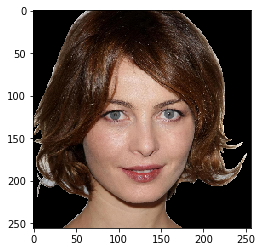

In [34]:
plt.imshow(np.moveaxis(X.repeat(2,1,1,1)[2].data.cpu().numpy(),0,-1))

In [15]:
torch.norm(Z, dim=1)

tensor([123.3642,  91.4208,  10.5982,  34.6669, 121.7191,  92.6423,  10.7737,
         34.6226], device='cuda:0', grad_fn=<NormBackward1>)

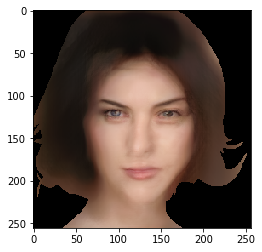

In [35]:
plt.imshow(np.moveaxis(Xhat[2].data.cpu().numpy(),0,-1))

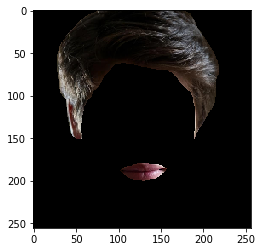

In [41]:
plt.imshow(np.moveaxis(X[0].data.cpu().numpy(),0,-1))

In [36]:
torch.save(model.state_dict(), './final_celeba_hq_encoder.pt')

## Using them as initializations

In [10]:
model = P_CelebA(device='cpu',nc=3, ndir=2 )
model.load_state_dict(torch.load('./final_celeba_hq_encoder.pt'))

In [11]:
gen = torch.nn.DataParallel(pg.Generator(depth=9)).to('cuda')
gen.load_state_dict(torch.load("GAN_GEN_SHADOW_8.pth", map_location='cuda'))

In [12]:
import csgm

In [13]:
image = np.moveaxis(celebahq_test[0][0].numpy(),0,-1)

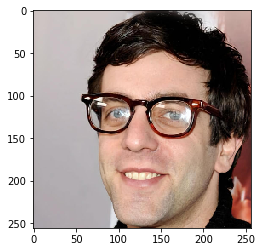

In [14]:
plt.imshow(image)

In [15]:
import skimage

In [16]:
import imp
imp.reload(image_utils)

<module 'image_utils' from '/home/kurtis/ImageAnchors/image_utils.py'>

(256, 256, 3) 0.0 1.0


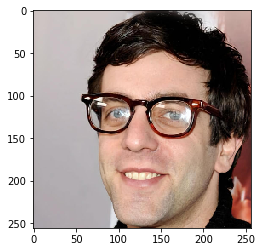

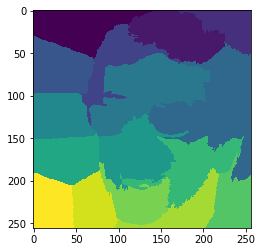

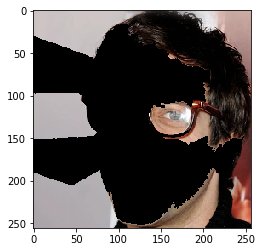

In [37]:
image =np.moveaxis(celebahq_test[0][0].numpy(),0,-1)
target = image.copy()
# t_image = t_image/255.
#target = image_list[0]/255 #(np.moveaxis(test_set[np.random.randint(len(test_set))][0].numpy(),0,-1))
plt.figure()
plt.imshow(target)
print(target.shape, np.min(target), np.max(target))

segments = skimage.segmentation.slic(target, n_segments=25, compactness=10)
plt.figure()
plt.imshow(segments)

exp_ = {}
exp_['feature'] = [i for i in range(len(segments)) if np.random.rand() > .5]
# exp_['feature'] = [0]
_,mask_exp = image_utils.create_mask(target,segments,exp_,rgb=True)
# mask_exp = np.tile(np.expand_dims(mask, -1), (1, 1, 3))
# plt.imshow(mask_exp)

plt.figure()

target = ((image * 2) - 1) * mask_exp
plt.imshow(image*mask_exp)

In [38]:
def encode(masked_image):
    return model(torch.FloatTensor(masked_image))

In [39]:
Z = torch.cat(encode(np.expand_dims(np.moveaxis((image*mask_exp),-1,0),0)),dim=0)

In [40]:
Z.shape

torch.Size([2, 512])

In [41]:
init_recon = nn.functional.interpolate(gen(Z.view(-1,512).cuda(), depth=8, alpha=1), size=(256,256)).data.cpu().numpy()

In [42]:
init_recon.shape

(2, 3, 256, 256)

(-0.5, 255.5, 255.5, -0.5)

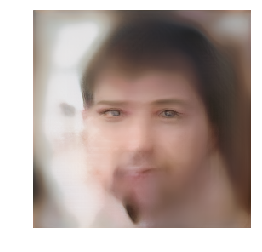

In [67]:
ok = np.moveaxis((init_recon[1] + 1)/2,0,-1) 
# ok[np.all(ok == [0,0,0],axis=-1)] = 1
plt.imshow(ok)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

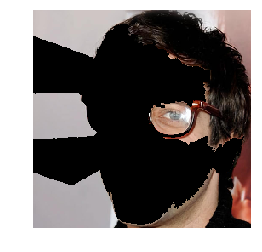

In [52]:
ok = image*mask_exp
# ok[np.all(ok == [0,0,0],axis=-1)] = 1
plt.imshow(ok)
plt.axis('off')

### Try with CSGM

In [33]:
imp.reload(csgm)

<module 'csgm' from '/home/kurtis/ImageAnchors/csgm.py'>

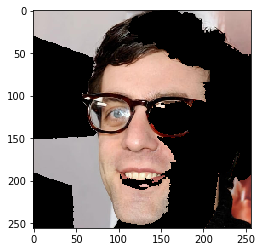

In [48]:
plt.imshow(image*mask_exp)

In [60]:
x = csgm.reconstruct_celebA_batch_early_remove(
    (2*image - 1)*mask_exp,
    np.moveaxis(mask_exp,-1,0),
    np.sum(mask_exp),
    gen,
    'cuda',
    2,
    4,
    threshold=0.05,
    lr = 1e-1,
    init_mu = encode(np.expand_dims(np.moveaxis((image*mask_exp),-1,0),0))
)

-1.0 1.0
103365.000000001
0.05
10 tensor([0.1019, 0.0928], device='cuda:0', grad_fn=<IndexBackward>)
20 tensor([0.0801, 0.0754], device='cuda:0', grad_fn=<IndexBackward>)
30 tensor([0.0719, 0.0700], device='cuda:0', grad_fn=<IndexBackward>)
40 tensor([0.0674, 0.0666], device='cuda:0', grad_fn=<IndexBackward>)
50 tensor([0.0646, 0.0639], device='cuda:0', grad_fn=<IndexBackward>)
60 tensor([0.0620, 0.0619], device='cuda:0', grad_fn=<IndexBackward>)
70 tensor([0.0600, 0.0602], device='cuda:0', grad_fn=<IndexBackward>)
80 tensor([0.0584, 0.0589], device='cuda:0', grad_fn=<IndexBackward>)
90 tensor([0.0572, 0.0579], device='cuda:0', grad_fn=<IndexBackward>)
100 tensor([0.0560, 0.0569], device='cuda:0', grad_fn=<IndexBackward>)
110 tensor([0.0549, 0.0561], device='cuda:0', grad_fn=<IndexBackward>)
120 tensor([0.0539, 0.0553], device='cuda:0', grad_fn=<IndexBackward>)
130 tensor([0.0529, 0.0545], device='cuda:0', grad_fn=<IndexBackward>)
140 tensor([0.0518, 0.0536], device='cuda:0', grad_fn=<

In [61]:
recon = np.moveaxis(x[2],1,-1)

Text(0.5, 0.94, 'Threshold = 0.05')

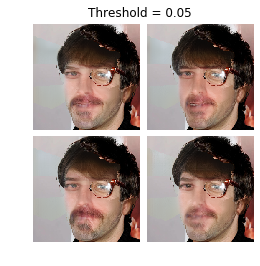

In [62]:
fig = plt.figure(figsize=(4,4))
ax = [plt.subplot(2,2,i+1) for i in range(4)]
plt.subplots_adjust(wspace=0.05, hspace=0.05);
for i in range(2):
    for j in range(2):
#         print(4*j + i)
        ax[2*j + i].set_axis_off()
        ax[2*j + i].imshow( ((recon[2*j + i]+((2*image-1) * mask_exp)) + 1)/2 )
plt.suptitle('Threshold = ' + str(0.05), y=0.94, fontsize=12)

(-0.5, 255.5, 255.5, -0.5)

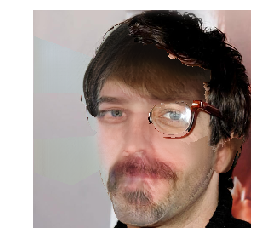

In [69]:
plt.imshow( ((recon[2]+((2*image-1) * mask_exp)) + 1)/2 )
plt.axis('off')